In [1]:
import xml.etree.ElementTree as ET
import glob
import os
import json
import shutil
from tqdm.notebook import tqdm

def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]

classes = []
input_dir = 'input/annotations/'
output_dir = 'input/labels/'
image_dir = 'input/images/'

# create the labels folder (output directory)
shutil.rmtree(output_dir, ignore_errors=True)
os.mkdir(output_dir)

# identify all the xml files in the annotations folder (input directory)
files = glob.glob(os.path.join(input_dir, '*.xml'))
# loop through each 
for fil in tqdm(files):
    basename = os.path.basename(fil)
    filename = os.path.splitext(basename)[0]
    # check if the label contains the corresponding image file
    if not os.path.exists(os.path.join(image_dir, f"{filename}.png")):
        print(f"{filename} image does not exist!")
        continue

    result = []

    # parse the content of the xml file
    tree = ET.parse(fil)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)

    for obj in root.findall('object'):
        label = obj.find("name").text
        # check for new classes and append to list
        if label not in classes:
            classes.append(label)
        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find("bndbox")]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)
        # convert data to string
        bbox_string = " ".join([str(x) for x in yolo_bbox])
        result.append(f"{index} {bbox_string}")
    if result:
        # generate a YOLO format text file for each xml file
        with open(os.path.join(output_dir, f"{filename}.txt"), "w", encoding="utf-8") as f:
            f.write("\n".join(result))

# generate the classes file as reference
with open('classes.txt', 'w', encoding='utf8') as f:
    f.write(json.dumps(classes))

  0%|          | 0/853 [00:00<?, ?it/s]

In [2]:
from PIL import Image, ImageDraw

def yolo_to_xml_bbox(bbox, w, h):
    # x_center, y_center width heigth
    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2
    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)
    return [xmin, ymin, xmax, ymax]

def draw_image(img, bboxes, classes):
    draw = ImageDraw.Draw(img)
    for i in range(len(bboxes)):
        if classes[i] == 0:
            c = 'green'
        elif classes[i] == 1:
            c = 'red'
        else:
            c = 'yellow'
        draw.rectangle(bboxes[i], outline=c, width=3)
    display(img)

In [3]:
def draw(file_num):
    image_filename = 'input/images/maksssksksss' + file_num + '.png'
    label_filename = 'input/labels/maksssksksss' + file_num + '.txt'
    bboxes = []
    classes = []

    img = Image.open(image_filename)
    with open(label_filename, 'r', encoding='utf8') as f:
        for line in f:
            data = line.strip().split(' ')
            bbox = [float(x) for x in data[1:]]
            bboxes.append(yolo_to_xml_bbox(bbox, img.width, img.height))
            classes.append(int(data[0]))

    draw_image(img, bboxes, classes)

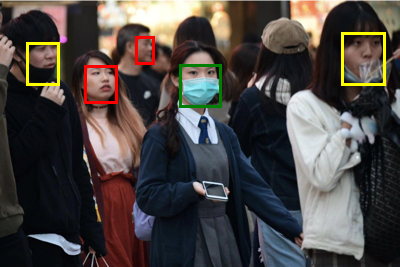

In [8]:
draw(file_num='250')

In [5]:
files = glob.glob(os.path.join('/home/gechengze/deep-learning/fdu/rmfd-yolov5-openvino/input/images', '*.png'))

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train, valid = train_test_split(files, test_size=0.3, random_state=1234)

In [8]:
len(train), len(valid)

(597, 256)

In [9]:
with open('./input/train.txt', 'w', encoding='utf8') as f:
    for img_path in train:
        f.write(img_path + '\n')
        
with open('./input/val.txt', 'w', encoding='utf8') as f:
    for img_path in valid:
        f.write(img_path + '\n')